# Primera Red 1000 epocas con step decay

In [1]:
#coding=utf-8
from keras.models import load_model
from utils.sample import Sample
from utils.black_scholes import raiz_ratio
import math
import numpy as np
from sklearn.metrics import r2_score
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

GPUs = len(tf.config.experimental.list_physical_devices('GPU'))
CPUs = len(tf.config.experimental.list_physical_devices('CPU'))

if GPUs > 0:
    
    print("Num GPUs Available: ", GPUs)
    print("Num CPUs Available: ", CPUs)
    config = tf.compat.v1.ConfigProto( device_count = \
                                      {'GPU': GPUs , 'CPU': CPUs}) 
    sess = tf.compat.v1.Session(config=config) 
    tf.compat.v1.keras.backend.set_session(sess)


Using TensorFlow backend.


In [2]:
wide = Sample(ratio=[0.4, 1.6], T=[0.2, 1.1],
              r=[0.02, 0.1], o=[0.01, 1])

N = 10**5 # Tamaño de la muestra

wide.create('wide', N=N)
x_wide, y_wide = wide.open('wide')

narrow = Sample(ratio=[0.5, 1.5], T=[0.3, 0.95],
                r=[0.03, 0.08], o=[0.02, 0.9])
narrow.create('narrow', N=N)
x_narrow, y_narrow = narrow.open('narrow')


wide is done ...
narrow is done ...


In [3]:
model = load_model('models/first.h5')

wide_f = pd.DataFrame(x_wide,
                    columns=['c/k', 'ratio', 'r', 'T'])
wide_f['o'] = y_wide
wide_predict = model.predict(x_wide)
wide_f['predicted'] = wide_predict
wide_f['diff'] = wide_f['o'] - wide_f['predicted']
wide_f['error'] = wide_f['diff'].apply(abs)

narrow_f = pd.DataFrame(x_narrow,
                    columns=['c/k', 'ratio', 'r', 'T'])
narrow_f['o'] = y_narrow
narrow_predict = model.predict(x_narrow)
narrow_f['predicted'] = narrow_predict
narrow_f['diff'] = narrow_f['o'] - narrow_f['predicted']
narrow_f['error'] = narrow_f['diff'].apply(abs)


In [4]:
wide_mse, wide_mae, wide_mape = tuple(model.evaluate(x_wide, y_wide)[1:])

narrow_mse, narrow_mae, narrow_mape = tuple(model.evaluate(x_narrow, y_narrow)[1:])


st = 'mse: {}\nmae: {}\nmape: {}'
print('\nWide:\n'+st.format(wide_mse, wide_mae, wide_mape))
print('\n\nNarrow:\n'+st.format(narrow_mse, narrow_mae, narrow_mape))

100000/100000 [==============================] - 8s 79us/step

Wide:
mse: 0.00031104180379770696
mae: 0.006013931706547737
mape: 9.039839744567871


Narrow:
mse: 0.00015173944120761007
mae: 0.004134080838412046
mape: 5.557677268981934


In [5]:
aux_des = (sum((wide_f['diff'] - np.array([0]*len(wide_f)))**2)/(len(wide_f)-1))**0.5
des_wide = round(aux_des,10) # desviacion estandar

aux_des = (sum((narrow_f['diff'] - np.array([0]*len(narrow_f)))**2)/(len(narrow_f)-1))**0.5
des_narrow = round(aux_des,10) # desviacion estandar



0.01763646181990911

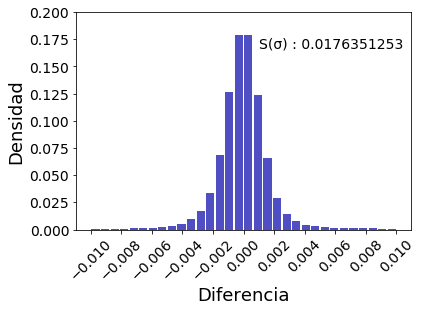

In [6]:
bins = np.linspace(-0.01, 0.01, 33)
plt.hist(wide_f['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)


plt.xticks(np.linspace(-0.01, 0.01, 11), rotation=45)
plt.ylabel("Densidad", fontsize=18)
plt.xlabel("Diferencia", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(np.arange(0,0.21,0.025),fontsize=14)
plt.text(0.001, 0.167,'S(\u03C3) : {}'.format(des_wide), fontsize=14)


plt.savefig('Predic_w_n',dpi=300, bbox_inches='tight')
plt.show()

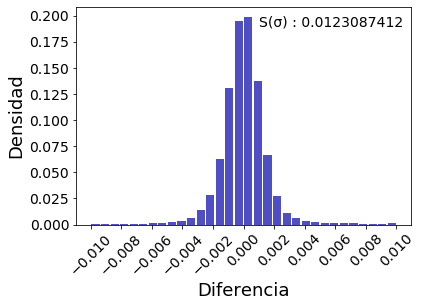

In [7]:
bins = np.linspace(-0.01, 0.01, 33)
plt.hist(narrow_f['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)


plt.xticks(np.linspace(-0.01, 0.01, 11), rotation=45)
plt.ylabel("Densidad", fontsize=18)
plt.xlabel("Diferencia", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.001, 0.19,'S(\u03C3) : {}'.format(des_narrow), fontsize=14)

plt.savefig('Predic_n_n',dpi=300, bbox_inches='tight')

plt.show()

In [8]:
#porcetaje que no se grafico con la muestra amplia
p = 100*len(wide_f[wide_f['error'] > 0.01])/N
print('No se grafico un {}% de la muestra amplia'.format(p))

#porcetaje que no se grafico con la muestra angosta
p = 100*len(narrow_f[narrow_f['error'] > 0.01])/N
print('\nNo se grafico un {}% de la muestra angosta'.format(p))

No se grafico un 11.034% de la muestra amplia

No se grafico un 8.78% de la muestra angosta


In [9]:
# r2 https://en.wikipedia.org/wiki/Coefficient_of_determination
r2_n = r2_score(y_narrow, narrow_f['predicted'])
r2_w = r2_score(y_wide, wide_f['predicted'])
print('r2 muestra amplia: ', r2_w)
print('\nr2 muestra angosta: ', r2_n)

r2 muestra amplia:  0.9961617590015301

r2 muestra angosta:  0.997644609964091


# Red logaritmica 1000 epocas con step decay

In [10]:
wide = Sample(ratio=[0.4, 1.6], T=[0.2, 1.1],
              r=[0.02, 0.1], o=[0.01, 1])
N = 10**5
wide.create('wide', log=True, N=N)
x_wide, y_wide = wide.open('wide', log=True)

narrow = Sample(ratio=[0.5, 1.5], T=[0.3, 0.95],
                r=[0.03, 0.08], o=[0.02, 0.9])

narrow.create('narrow',log=True, N=N)
x_narrow, y_narrow = narrow.open('narrow', log=True)


wide is done ...
narrow is done ...


In [11]:
model = load_model('models/1000_log.h5')

wide_s = pd.DataFrame(x_wide,
                    columns=['c/k', 'ratio', 'r', 'T'])
wide_s['o'] = y_wide
wide_predict = model.predict(x_wide)
wide_s['predicted'] = wide_predict
wide_s['diff'] = wide_s['predicted'] - wide_s['o'] 
wide_s['error'] = wide_s['diff'].apply(abs)

narrow_s = pd.DataFrame(x_narrow,
                    columns=['c/k', 'ratio', 'r', 'T'])
narrow_s['o'] = y_narrow
narrow_predict = model.predict(x_narrow)
narrow_s['predicted'] = narrow_predict
narrow_s['diff'] = narrow_s['predicted'] - narrow_s['o']  
narrow_s['error'] = narrow_s['diff'].apply(abs)


wide_mse, wide_mae, wide_mape = tuple(model.evaluate(x_wide, y_wide)[1:])

narrow_mse, narrow_mae, narrow_mape = tuple(model.evaluate(x_narrow,
                                                           y_narrow)[1:])


st = 'mse: {}\nmae: {}\nmape: {}'
print('\nWide:\n'+st.format(wide_mse, wide_mae, wide_mape))
print('\n\nNarrow:\n'+st.format(narrow_mse, narrow_mae, narrow_mape))

100000/100000 [==============================] - 12s 124us/step

Wide:
mse: 6.316571443676366e-08
mae: 0.000192259976756759
mape: 0.060015153139829636


Narrow:
mse: 5.588842455495069e-08
mae: 0.00018376647494733334
mape: 0.062156885862350464


In [23]:
aux_des = (sum((wide_s['diff'] - np.array([0]*len(wide_s)))**2)/(len(wide_s)-1))**0.5
des_wide = round(aux_des,10) # desviacion estandar

aux_des = (sum((narrow_s['diff'] - np.array([0]*len(narrow_s)))**2)/(len(narrow_s)-1))**0.5
des_narrow = round(aux_des,10) # desviacion estandar

narrow_s['diff'].sum()/len(narrow_s)


-4.400360783698321e-06

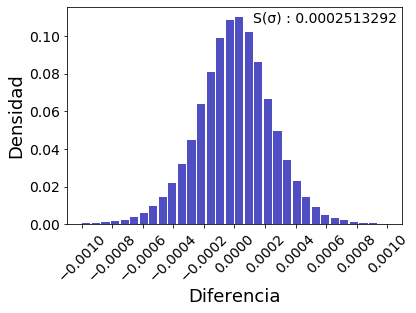

In [13]:
bins = np.linspace(-0.001, 0.001, 33)
plt.hist(wide_s['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)


plt.xticks(np.linspace(-0.001, 0.001, 11), rotation=45)
plt.ylabel("Densidad", fontsize=18)
plt.xlabel("Diferencia", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.00012, 0.107,'S(\u03C3) : {}'.format(des_wide), fontsize=14)

plt.savefig('Predic_w_log_mil',dpi=300, bbox_inches='tight')

plt.show()

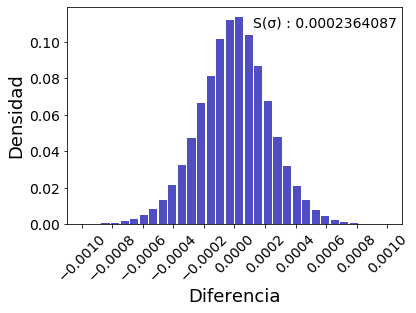

In [14]:
bins = np.linspace(-0.001, 0.001, 33)
plt.hist(narrow_s['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.xticks(np.linspace(-0.001, 0.001, 11), rotation=45)

plt.ylabel("Densidad", fontsize=18)
plt.xlabel("Diferencia", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.00012, 0.108,'S(\u03C3) : {}'.format(des_narrow), fontsize=14)

plt.savefig('Predic_n_log_mil',dpi=300, bbox_inches='tight')

plt.show()

In [15]:
#porcetaje que no se grafico con la muestra amplia
p = 100*len(wide_s[wide_s['error'] > 0.001])/N
print('No se grafico un {}% de la muestra amplia'.format(p))

#porcetaje que no se grafico con la muestra angosta
p = 100*len(narrow_s[narrow_s['error'] > 0.001])/N
print('\nNo se grafico un {}% de la muestra angosta'.format(p))

No se grafico un 0.182% de la muestra amplia

No se grafico un 0.069% de la muestra angosta


In [16]:
# r2 https://en.wikipedia.org/wiki/Coefficient_of_determination
r2_n = r2_score(y_narrow, narrow_s['predicted'])
r2_w = r2_score(y_wide, wide_s['predicted'])
print('r2 muestra amplia: ', r2_w)
print('\nr2 muestra angosta: ', r2_n)

r2 muestra amplia:  0.9999990956953005

r2 muestra angosta:  0.9999990256147415


# Red logaritmica 3000 epocas con step decay modificado

In [17]:
model = load_model('models/second.h5')

wide_s = pd.DataFrame(x_wide,
                    columns=['c/k', 'ratio', 'r', 'T'])
wide_s['o'] = y_wide
wide_predict = model.predict(x_wide)
wide_s['predicted'] = wide_predict
wide_s['diff'] = wide_s['predicted'] - wide_s['o'] 
wide_s['error'] = wide_s['diff'].apply(abs)

narrow_s = pd.DataFrame(x_narrow,
                    columns=['c/k', 'ratio', 'r', 'T'])
narrow_s['o'] = y_narrow
narrow_predict = model.predict(x_narrow)
narrow_s['predicted'] = narrow_predict
narrow_s['diff'] = narrow_s['predicted'] - narrow_s['o']  
narrow_s['error'] = narrow_s['diff'].apply(abs)


wide_mse, wide_mae, wide_mape = tuple(model.evaluate(x_wide, y_wide)[1:])

narrow_mse, narrow_mae, narrow_mape = tuple(model.evaluate(x_narrow,
                                                           y_narrow)[1:])


st = 'mse: {}\nmae: {}\nmape: {}'
print('\nWide:\n'+st.format(wide_mse, wide_mae, wide_mape))
print('\n\nNarrow:\n'+st.format(narrow_mse, narrow_mae, narrow_mape))

100000/100000 [==============================] - 11s 106us/step

Wide:
mse: 4.6365020267558066e-08
mae: 0.00016563113604206592
mape: 0.051440510898828506


Narrow:
mse: 4.028013478318826e-08
mae: 0.0001569822197780013
mape: 0.05292699858546257


In [18]:
aux_des = (sum((wide_s['diff'] - np.array([0]*len(wide_s)))**2)/(len(wide_s)-1))**0.5
des_wide = round(aux_des,10) # desviacion estandar

aux_des = (sum((narrow_s['diff'] - np.array([0]*len(narrow_s)))**2)/(len(narrow_s)-1))**0.5
des_narrow = round(aux_des,10) # desviacion estandar

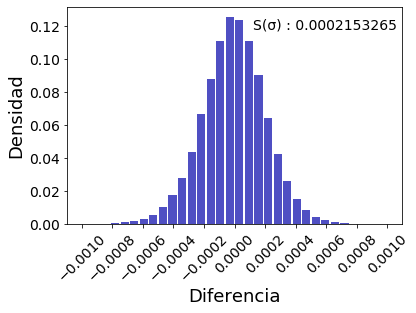

In [19]:
bins = np.linspace(-0.001, 0.001, 33)
plt.hist(wide_s['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)


plt.xticks(np.linspace(-0.001, 0.001, 11), rotation=45)
plt.ylabel("Densidad", fontsize=18)
plt.xlabel("Diferencia", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.00012, 0.118,'S(\u03C3) : {}'.format(des_wide), fontsize=14)
plt.savefig('Predic_w_log_3mil',dpi=300, bbox_inches='tight')

plt.show()

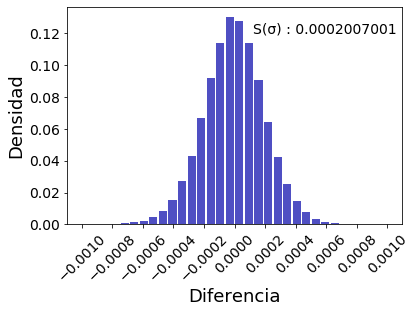

In [20]:
bins = np.linspace(-0.001, 0.001, 33)
plt.hist(narrow_s['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.xticks(np.linspace(-0.001, 0.001, 11), rotation=45)

plt.ylabel("Densidad", fontsize=18)
plt.xlabel("Diferencia", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.00012, 0.12,'S(\u03C3) : {}'.format(des_narrow), fontsize=14)
plt.savefig('Predic_n_log_3mil',dpi=300, bbox_inches='tight')

plt.show()

In [21]:
#porcetaje que no se grafico con la muestra amplia
p = 100*len(wide_s[wide_s['error'] > 0.001])/N
print('No se grafico un {}% de la muestra amplia'.format(p))

#porcetaje que no se grafico con la muestra angosta
p = 100*len(narrow_s[narrow_s['error'] > 0.001])/N
print('\nNo se grafico un {}% de la muestra angosta'.format(p))

No se grafico un 0.07% de la muestra amplia

No se grafico un 0.019% de la muestra angosta


In [22]:
# r2 https://en.wikipedia.org/wiki/Coefficient_of_determination
r2_n = r2_score(y_narrow, narrow_s['predicted'])
r2_w = r2_score(y_wide, wide_s['predicted'])
print('r2 muestra amplia: ', r2_w)
print('\nr2 muestra angosta: ', r2_n)

r2 muestra amplia:  0.999999336220989

r2 muestra angosta:  0.9999992977380426
